<a href="https://colab.research.google.com/github/poovarasan13/Multimodal-Meme-Disagreement-Detector/blob/master/meme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from sklearn.model_selection import train_test_split
import os
import warnings

# Suppress potential warnings from the Hugging Face library during model loading
warnings.filterwarnings("ignore")

# --- CONFIGURATION (CRITICAL: UPDATE THESE PATHS) ---
CSV_PATH = 'combined_data.csv'
# You MUST change this to the actual folder path where your 'image_1.jpg', 'image_2.jpeg', etc. are stored.
# IMAGE_DIR = './path/to/your/meme/images/'
IMAGE_DIR = '/content/drive/MyDrive/dataset/'
# --- Column Mappings (Verified from Inspection) ---
IMAGE_PATH_COL = 'image_name'
TEXT_COL = 'text_corrected'
HUMAN_LABEL_COL = 'multimodal_annotation_humans'
AI_LABEL_COL = 'multimodal_annotation_ai'

# --- Hyperparameters ---
DISAGREEMENT_LOSS_WEIGHT = 2.0 # Lambda (λ): Increase to prioritize disagreement learning
EPOCHS = 5
BATCH_SIZE = 16
LEARNING_RATE = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


✅ CSV Loaded Successfully!

     image_name                                     text_corrected  \
0   image_1.jpg  LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...   
1  image_2.jpeg  The best of #10YearChallenge! Completed in les...   
2   image_3.JPG  Sam Thorne @Strippin ( Follow Follow Saw every...   
3   image_4.png              10 Year Challenge - Sweet Dee Edition   
4   image_5.png  10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...   

  multimodal_annotation_ai                          multimodal_explanation_ai  \
0                  general        Making fun of Facebook trends and followers   
1          twisted_meaning  Contrasts traditional cooking with gas upgrade...   
2                  general  Comparing self-pictures to trash bins humorous...   
3                  general  Playful comparison highlighting contrast in 10...   
4          twisted_meaning  Contrasts two very different images implying e...   

  unimodal_annotation_ai                            unimodal_exp

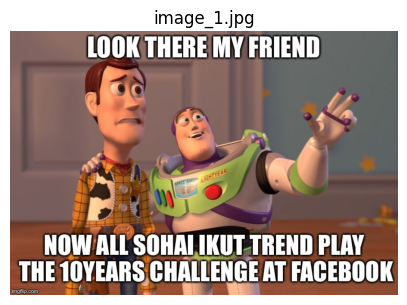

In [4]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os

# --- Paths ---
CSV_PATH = 'combined_data.csv'
IMAGE_DIR = '/content/drive/MyDrive/dataset/'

# --- Load CSV ---
df = pd.read_csv(CSV_PATH)
print("✅ CSV Loaded Successfully!\n")
print(df.head())

# --- Column Name ---
IMAGE_PATH_COL = 'image_name'

# --- Select one image to display ---
sample_image_name = df[IMAGE_PATH_COL].iloc[0]  # first image name
image_path = os.path.join(IMAGE_DIR, sample_image_name)

print(f"🖼️ Displaying Image: {image_path}")

# --- Load and display the image ---
if os.path.exists(image_path):
    img = Image.open(image_path)

    # --- Show image preview ---
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(sample_image_name)
    plt.show()
else:
    print("❌ Image not found at:", image_path)


In [5]:
def load_and_preprocess_data(csv_path, img_dir):
    """Loads CSV, generates the Disagreement Flag, and encodes Human Labels."""
    df = pd.read_csv(csv_path)

    # 1. Create the Disagreement Flag
    # Disagreement is 1 if human and AI labels are NOT the same.
    disagree_mask = df[HUMAN_LABEL_COL] != df[AI_LABEL_COL]
    df['disagreement_flag'] = disagree_mask.astype(int)

    # 2. Encode the Human Label (Ground Truth for primary classification)
    emotion_labels = df[HUMAN_LABEL_COL].unique().tolist()
    emotion_map = {label: i for i, label in enumerate(emotion_labels)}
    df['target_emotion'] = df[HUMAN_LABEL_COL].map(emotion_map)

    # 3. Create full image path column
    df['full_image_path'] = df[IMAGE_PATH_COL].apply(lambda x: os.path.join(img_dir, x))

    # Clean data
    df.dropna(subset=[IMAGE_PATH_COL, TEXT_COL, 'target_emotion', 'disagreement_flag'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    num_labels = len(emotion_labels)
    emotion_map_inv = {v: k for k, v in emotion_map.items()}

    print(f"Data processed. Total samples: {len(df)}")
    print(f"Primary classification labels: {emotion_labels}")
    print(f"Disagreement ratio (1=Disagree): {df['disagreement_flag'].mean():.2f}")

    return df, num_labels, emotion_map_inv


class MemeDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load Image and Text
        try:
            image = Image.open(row['full_image_path']).convert("RGB")
        except FileNotFoundError:
            # Handle missing image gracefully (e.g., load a black image or skip, for simplicity we stop here)
            raise FileNotFoundError(f"Image not found at: {row['full_image_path']}. Check your IMAGE_DIR setting.")

        text = str(row[TEXT_COL])

        # Process inputs using CLIP's processor
        inputs = self.processor(
            text=text,
            images=image,
            return_tensors="pt",
            padding='max_length',
            truncation=True
        )

        # Prepare targets
        target_emotion = torch.tensor(row['target_emotion'], dtype=torch.long)
        target_disagreement = torch.tensor(row['disagreement_flag'], dtype=torch.float)

        return {
            'pixel_values': inputs['pixel_values'].squeeze(),
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'target_emotion': target_emotion,
            'target_disagreement': target_disagreement
        }

In [6]:
class MemeDataset(Dataset):
    def __init__(self, df, processor, img_dir):
        self.df = df
        self.processor = processor
        self.img_dir = img_dir # Base directory where images are stored

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load Image
        img_path = row['full_image_path']
        try:
            image = Image.open(img_path).convert("RGB")
        except (FileNotFoundError, OSError) as e:
            print(f"Warning: Skipping sample due to error loading image at {img_path}: {e}")
            # Return a None or a placeholder, which will need to be handled in the DataLoader or training loop
            # For simplicity here, we'll raise an error, but a more robust solution might return None
            # and filter in the DataLoader's collate_fn.
            # A better approach for skipping: return None and handle in collate_fn
            # But given the current loop structure, raising might be simpler to diagnose which image
            raise e # Re-raise the error to stop the batch and show the problematic image path


        # Get Text
        text = str(row[TEXT_COL])

        # Process inputs using the VLM's processor
        inputs = self.processor(
            text=text,
            images=image,
            return_tensors="pt",
            padding='max_length',
            truncation=True
        )

        # Prepare targets
        # Target for primary task (Human Label - Emotion)
        target_emotion = torch.tensor(row['target_emotion'], dtype=torch.long)

        # Target for novel disagreement task (Binary)
        target_disagreement = torch.tensor(row['disagreement_flag'], dtype=torch.float)

        return {
            'pixel_values': inputs['pixel_values'].squeeze(),
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'target_emotion': target_emotion,
            'target_disagreement': target_disagreement
        }

In [7]:
class DisagreementTransformer(nn.Module):
    def __init__(self, num_emotion_labels):
        super().__init__()
        # Use CLIP-ViT-Base as the backbone
        self.vlm = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

        # Freeze the VLM backbone (highly recommended)
        for param in self.vlm.parameters():
            param.requires_grad = False

        # Feature dimension (512 for CLIP-B/32)
        embedding_dim = self.vlm.config.projection_dim

        # --- 1. Primary Classification Head (AI Annotation) ---
        # Predicts the Human Label (Emotion/Sarcasm Intensity)
        self.emotion_head = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_emotion_labels)
        )

        # --- 2. Disagreement Modeling Module (Novel Head) ---
        # Predicts the probability of Human-AI disagreement (Binary)
        self.disagreement_head = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()        # Output probability
        )

    def forward(self, pixel_values, input_ids, attention_mask):
        # Get multimodal features from the VLM
        outputs = self.vlm(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values
        )

        # Simple fusion: sum of image and text embeddings
        # This creates a joint representation vector
        multimodal_features = outputs.text_embeds + outputs.image_embeds

        # Pass features through the two independent heads
        emotion_logits = self.emotion_head(multimodal_features)
        disagreement_prob = self.disagreement_head(multimodal_features)

        return emotion_logits, disagreement_prob.squeeze()

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.utils.data.dataloader # Need this for default_collate
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from sklearn.model_selection import train_test_split
import os
import warnings
import sys

# Suppress potential warnings from Hugging Face during model loading
warnings.filterwarnings("ignore")

# --- CONFIGURATION (Your provided updates) ---
CSV_PATH = "combined_data.csv"
IMAGE_DIR = '/content/drive/MyDrive/dataset/'

# --- Column Mappings (verified) ---
IMAGE_PATH_COL = "image_name"
TEXT_COL = "text_corrected"
HUMAN_LABEL_COL = "multimodal_annotation_humans"
AI_LABEL_COL = "multimodal_annotation_ai"

# --- Hyperparameters ---
DISAGREEMENT_LOSS_WEIGHT = 2.0  # λ: prioritize disagreement learning
EPOCHS = 5
BATCH_SIZE = 16
LEARNING_RATE = 1e-4

# --- Device setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# --- Sanity check ---
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"❌ CSV not found at: {CSV_PATH}")

if not os.path.exists(IMAGE_DIR):
    print(f"❌ Image directory not found at: {IMAGE_DIR}. Please check the path.")
    sys.exit(1)
else:
    print(f"📁 Found images directory: {IMAGE_DIR}")
    print(f"📄 CSV file loaded from: {CSV_PATH}")

# ==============================================================================
# 1. DATA PROCESSING AND DATASET CLASS (FIXED)
# ==============================================================================

def load_and_preprocess_data(csv_path, img_dir):
    """Loads CSV, generates the Disagreement Flag, and encodes Human Labels."""
    df = pd.read_csv(csv_path)

    # 1. Check for crucial columns
    required_cols = [IMAGE_PATH_COL, TEXT_COL, HUMAN_LABEL_COL, AI_LABEL_COL]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"CRITICAL ERROR: Column '{col}' not found in CSV.")

    # 2. Create the Disagreement Flag (Target for Disagreement Module)
    disagree_mask = df[HUMAN_LABEL_COL] != df[AI_LABEL_COL]
    df['disagreement_flag'] = disagree_mask.astype(int)

    # 3. Encode the Human Label (Ground Truth for primary classification)
    emotion_labels = df[HUMAN_LABEL_COL].unique().tolist()
    emotion_map = {label: i for i, label in enumerate(emotion_labels)}
    df['target_emotion'] = df[HUMAN_LABEL_COL].map(emotion_map)

    # 4. Create full image path column
    df['full_image_path'] = df[IMAGE_PATH_COL].apply(lambda x: os.path.join(img_dir, x))

    # Clean data
    df.dropna(subset=['full_image_path', TEXT_COL, 'target_emotion', 'disagreement_flag'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    num_labels = len(emotion_labels)
    emotion_map_inv = {v: k for k, v in emotion_map.items()}

    print(f"\nData processed. Total samples: {len(df)}")
    print(f"Primary classification labels: {emotion_labels}")
    print(f"Disagreement ratio (1=Disagree): {df['disagreement_flag'].mean():.2f}")

    return df, num_labels, emotion_map_inv


class MemeDataset(Dataset):
    def __init__(self, df, processor): # Removed IMAGE_DIR from here as it's in df
        self.df = df
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # --- FIX: Gracefully handle image loading errors and return None ---
        try:
            # We must set this to True to handle truncated files that PIL would otherwise hide
            Image.MAX_IMAGE_PIXELS = None
            image = Image.open(row['full_image_path']).convert("RGB")
            image.verify() # Explicit check for truncated file data
            image = Image.open(row['full_image_path']).convert("RGB") # Reopen after verify
        except Exception as e:
            # Print a warning and RETURN NONE to skip this sample
            sys.stderr.write(f"⚠️ Warning: Skipping corrupted image {row[IMAGE_PATH_COL]}. Error: {e}\n")
            return None

        text = str(row[TEXT_COL])
        # ----------------------------------------------------------------------

        # Process inputs using CLIP's processor
        inputs = self.processor(
            text=text,
            images=image,
            return_tensors="pt",
            padding='max_length',
            truncation=True
        )

        # Prepare targets
        target_emotion = torch.tensor(row['target_emotion'], dtype=torch.long)
        target_disagreement = torch.tensor(row['disagreement_flag'], dtype=torch.float)

        return {
            'pixel_values': inputs['pixel_values'].squeeze(),
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'target_emotion': target_emotion,
            'target_disagreement': target_disagreement
        }

def collate_fn_skip_none(batch):
    """
    Custom collate function that filters out samples that returned None from the Dataset.
    """
    # Filter out None values
    batch = [item for item in batch if item is not None]

    if len(batch) == 0:
        # If the entire batch was corrupted, return None to be handled in the training loop
        return None

    # Use PyTorch's default collate function on the remaining valid items
    return torch.utils.data.dataloader.default_collate(batch)


# ==============================================================================
# 2. CUSTOM MULTIMODAL MODEL DEFINITION (Unchanged)
# ==============================================================================

class DisagreementTransformer(nn.Module):
    def __init__(self, num_emotion_labels):
        super().__init__()
        self.vlm = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        for param in self.vlm.parameters():
            param.requires_grad = False
        embedding_dim = self.vlm.config.projection_dim

        self.emotion_head = nn.Sequential(
            nn.Linear(embedding_dim, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, num_emotion_labels)
        )
        self.disagreement_head = nn.Sequential(
            nn.Linear(embedding_dim, 128), nn.ReLU(), nn.Dropout(0.3), nn.Linear(128, 1), nn.Sigmoid()
        )

    def forward(self, pixel_values, input_ids, attention_mask):
        outputs = self.vlm(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
        multimodal_features = outputs.text_embeds + outputs.image_embeds
        emotion_logits = self.emotion_head(multimodal_features)
        disagreement_prob = self.disagreement_head(multimodal_features)
        return emotion_logits, disagreement_prob.squeeze()


# ==============================================================================
# 3. TRAINING EXECUTION (FIXED)
# ==============================================================================

# --- A. Data Loading and Preparation ---
df_processed, num_labels, emotion_map_inv = load_and_preprocess_data(CSV_PATH, IMAGE_DIR)

if len(df_processed) == 0:
    print("Cannot train: No data samples remaining after preprocessing/cleaning.")
    sys.exit(1)

# Split data
train_df, val_df = train_test_split(
    df_processed, test_size=0.1, random_state=42, stratify=df_processed['disagreement_flag']
)

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Create Datasets
train_dataset = MemeDataset(train_df, processor)
val_dataset = MemeDataset(val_df, processor)

# --- CRITICAL CHANGE: Apply the custom collate_fn to filter out 'None' samples ---
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn_skip_none
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn_skip_none
)

# --- B. Model and Training Setup ---
model = DisagreementTransformer(num_labels).to(device)
loss_fn_emotion = nn.CrossEntropyLoss()
loss_fn_disagreement = nn.BCELoss()

trainable_params = list(model.emotion_head.parameters()) + list(model.disagreement_head.parameters())
optimizer = optim.AdamW(trainable_params, lr=LEARNING_RATE)

# --- C. Training Loop ---
print("\nStarting Training...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    valid_batches = 0 # Track valid batches for accurate average loss

    for batch in train_loader:
        # --- CRITICAL CHECK: Skip if collate_fn returned None (entire batch was bad) ---
        if batch is None:
            continue

        # Increment valid batch counter
        valid_batches += 1

        # Move data to device
        pixel_values = batch['pixel_values'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        target_emotion = batch['target_emotion'].to(device)
        target_disagreement = batch['target_disagreement'].to(device)

        optimizer.zero_grad()

        # Forward pass
        emotion_logits, disagreement_prob = model(pixel_values, input_ids, attention_mask)

        # Calculate losses
        loss_emotion = loss_fn_emotion(emotion_logits, target_emotion)
        loss_disagreement = loss_fn_disagreement(disagreement_prob, target_disagreement)

        # Calculate TOTAL MULTI-TASK LOSS
        loss = loss_emotion + DISAGREEMENT_LOSS_WEIGHT * loss_disagreement

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate average loss only over valid batches
    avg_loss = total_loss / valid_batches if valid_batches > 0 else 0
    print(f"Epoch {epoch+1}/{EPOCHS} | Average Training Loss: {avg_loss:.4f}")

print("\nTraining complete. Model weights are ready for prediction.")
MODEL_WEIGHTS_PATH = 'multimodal_disagreement_model.pth'
torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
print(f"✅ Model weights saved successfully to: {MODEL_WEIGHTS_PATH}")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✅ Using device: cpu
📁 Found images directory: /content/drive/MyDrive/dataset/
📄 CSV file loaded from: combined_data.csv

Data processed. Total samples: 6905
Primary classification labels: ['general', 'not_sarcastic', 'twisted_meaning', 'very_twisted']
Disagreement ratio (1=Disagree): 0.61


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]


Starting Training...


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [ ]:
import torch
import torch.nn as nn
from PIL import Image
from transformers import CLIPProcessor, CLIPModel # CLIPModel is now crucial
import os
import gradio as gr
import numpy as np
import sys

# ==============================================================================
# 0. DEFINITIONS AND SETUP
# ==============================================================================

# --- IMPORTANT: Replace this path with the location of your saved model weights ---
WEIGHTS_PATH = 'multimodal_disagreement_model.pth'

# Real DisagreementTransformer Class (Deterministic Feature Extraction)
class DisagreementTransformer(nn.Module):
    def __init__(self, num_emotion_labels):
        super().__init__()
        # Load the actual CLIP backbone
        self.vlm = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

        for param in self.vlm.parameters():
            param.requires_grad = False

        self.embedding_dim = self.vlm.config.projection_dim

        self.emotion_head = nn.Sequential(
            nn.Linear(self.embedding_dim, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, num_emotion_labels)
        )
        self.disagreement_head = nn.Sequential(
            nn.Linear(self.embedding_dim, 128), nn.ReLU(), nn.Dropout(0.3), nn.Linear(128, 1), nn.Sigmoid()
        )

    def forward(self, pixel_values, input_ids, attention_mask):
        # CORRECT: Use the actual CLIP feature extraction
        outputs = self.vlm(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values
        )

        # Fusion method: sum of embeddings
        multimodal_features = outputs.text_embeds + outputs.image_embeds

        emotion_logits = self.emotion_head(multimodal_features)
        disagreement_prob = self.disagreement_head(multimodal_features)
        return emotion_logits, disagreement_prob.squeeze()


# Example Label Mapping (MUST match your training data labels)
emotion_map_inv = {0: 'general', 1: 'not_sarcastic', 2: 'twisted_meaning', 3: 'very_twisted'}
num_labels = len(emotion_map_inv)
available_labels = list(emotion_map_inv.values())

# --- Global Variable Instantiation ---
device = torch.device("cpu")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Create model instance and load weights
model = DisagreementTransformer(num_labels).to(device)

try:
    # ⬅️ FIX: Loading the saved, deterministic weights
    model.load_state_dict(torch.load(WEIGHTS_PATH, map_location=device))
    print(f"✅ Successfully loaded trained model weights from: {WEIGHTS_PATH}")
except FileNotFoundError:
    print(f"❌ ERROR: Weights file not found at '{WEIGHTS_PATH}'. Predictions will be based on an UNTRAINED model and highly inconsistent or random.")
except Exception as e:
    print(f"❌ ERROR loading weights: {e}. Predictions may be inconsistent.")

model.eval()


# ==============================================================================
# 1. CORE PREDICTION LOGIC (Now fully deterministic)
# ==============================================================================

def predict_meme_disagreement_core(model, processor, image: Image.Image, text_content: str) -> tuple:
    """Core function to get AI prediction and disagreement likelihood."""
    model.eval()

    inputs = processor(
        text=text_content,
        images=image.convert("RGB"),
        return_tensors="pt",
        padding='max_length',
        truncation=True
    )

    pixel_values = inputs['pixel_values'].to(device)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        emotion_logits, disagreement_prob = model(pixel_values, input_ids, attention_mask)

        predicted_emotion_idx = torch.argmax(emotion_logits, dim=1).item()
        ai_annotation = emotion_map_inv[predicted_emotion_idx]
        disagreement_likelihood = disagreement_prob.item()

    return ai_annotation, disagreement_likelihood


# ==============================================================================
# 2. GRADIO INTERFACE FUNCTION
# ==============================================================================

def run_meme_analysis(image: np.ndarray, text_content: str, human_annotation: str):
    """
    Main function called by Gradio to run the analysis and display results.
    """
    # Initialize a base status message
    status_message_base = "Analysis Complete!"

    # Handle initial input errors first
    if image is None:
        return "⚠️ Please upload a meme image.", "", "", "STATUS: Waiting for image."

    if not text_content:
        return "⚠️ Meme text is required.", "", "", "STATUS: Missing text."

    if human_annotation not in available_labels:
        return "⚠️ Please select a valid human annotation.", "", "", "STATUS: Invalid annotation selected."

    pil_image = Image.fromarray(image)

    # --- A. Get AI Predictions (Deterministic) ---
    ai_annotation, dis_likelihood = predict_meme_disagreement_core(
        model, processor, pil_image, text_content
    )
    # The log that was not showing up
    debug_log = f"LOG: AI Annotation={ai_annotation}, Likelihood={dis_likelihood:.2f}"

    # --- B. Determine Final Status ---
    if ai_annotation.lower() == human_annotation.lower():
        final_status = "AGREEMENT ✅ (AI prediction matches Human Annotation)"
        status_color = "green"
    else:
        final_status = "DISAGREEMENT ❌ (AI prediction differs from Human Annotation)"
        status_color = "red"

    # --- C. Format Output for UI ---
    ai_output_str = f"**Predicted Label:** <span style='color:blue'>{ai_annotation}</span>"

    dis_alert = "HIGH LIKELIHOOD" if dis_likelihood >= 0.5 else "LOW LIKELIHOOD"
    dis_color = "red" if dis_likelihood >= 0.5 else "darkgreen"

    disagreement_str = (
        f"**Predicted Disagreement:** <span style='color:{dis_color}'>{dis_alert}</span>\n"
        f"Likelihood Score: **{dis_likelihood:.2f}**"
    )

    final_status_str = f"<span style='font-size: 1.2em; font-weight: bold; color:{status_color}'>{final_status}</span>"

    # 🌟 FIX: Combine the default status message with the debug log
    combined_status_log = f"{status_message_base}\n{debug_log}"

    # The return now correctly includes the combined log as the 4th output
    return ai_output_str, disagreement_str, final_status_str, combined_status_log


# ==============================================================================
# 3. GRADIO UI DEFINITION AND LAUNCH
# ==============================================================================

input_image = gr.Image(type="numpy", label="Upload Meme Image")
input_text = gr.Textbox(label="Overlaid Text Content (Required for Transformer)")
input_human_annotation = gr.Dropdown(
    label="Manual Human Annotation (Ground Truth)",
    choices=available_labels,
    multiselect=False,
    value=available_labels[0]
)

output_ai_annotation = gr.Markdown(label="🤖 AI ANNOTATION (Multimodal Transformer Prediction)")
output_dis_prediction = gr.Markdown(label="🧠 AI DISAGREEMENT PREDICTION (0.00 - 1.00)")
output_final_status = gr.Markdown(label="✅ FINAL AGREEMENT CHECK (AI vs. Human)")
status_message = gr.Textbox(label="Status Log", interactive=False)


iface = gr.Interface(
    fn=run_meme_analysis,
    inputs=[input_image, input_text, input_human_annotation],
    outputs=[output_ai_annotation, output_dis_prediction, output_final_status, status_message],
    title="Multimodal Meme Disagreement Detector",
    description="Upload a meme and provide the text. The AI predicts the emotion/sarcasm and the probability of human disagreement. You then provide the ground truth (Human Annotation) for validation."
)

print("\n🚀 Starting Gradio Interface...")
iface.launch()

In [ ]:
# import torch
# import torch.nn as nn
# from PIL import Image
# from transformers import CLIPProcessor
# import os
# import io
# import gradio as gr
# import numpy as np

# # ==============================================================================
# # 0. MOCK SETUP (REQUIRED TO RUN INFERENCE)
# #
# # NOTE: In a real deployment, you would replace the MockDisagreementTransformer
# # with your actual trained DisagreementTransformer class and load its weights.
# # ==============================================================================

# # Placeholder Model Definition (Must match your training architecture)
# class DisagreementTransformer(nn.Module):
#     def __init__(self, num_emotion_labels):
#         super().__init__()
#         # Simplified mock structure mimicking the output shape
#         self.embedding_dim = 512
#         self.vlm = nn.Identity()
#         self.emotion_head = nn.Linear(self.embedding_dim, num_emotion_labels)
#         self.disagreement_head = nn.Sequential(nn.Linear(self.embedding_dim, 1), nn.Sigmoid())

#     def forward(self, pixel_values, input_ids, attention_mask):
#         # Generates mock features for demonstration
#         mock_multimodal_features = torch.randn(pixel_values.shape[0], self.embedding_dim).to(pixel_values.device)
#         emotion_logits = self.emotion_head(mock_multimodal_features)
#         disagreement_prob = self.disagreement_head(mock_multimodal_features)
#         return emotion_logits, disagreement_prob.squeeze()

# # Example Label Mapping (MUST match your training data labels)
# emotion_map_inv = {0: 'general', 1: 'not_sarcastic', 2: 'twisted_meaning', 3: 'very_twisted'}
# num_labels = len(emotion_map_inv)
# available_labels = list(emotion_map_inv.values())

# # --- Instantiate Global Variables ---
# device = torch.device("cpu")
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# # Create a model instance (REPLACE with loading your actual trained model)
# model = DisagreementTransformer(num_labels).to(device)
# # To load real weights: model.load_state_dict(torch.load('path/to/weights.pth', map_location=device))
# model.eval()


# # ==============================================================================
# # 1. CORE PREDICTION LOGIC (Adapted for Gradio input)
# # ==============================================================================

# def predict_meme_disagreement_core(model, processor, image: Image.Image, text_content: str) -> tuple:
#     """Core function to get AI prediction and disagreement likelihood."""
#     model.eval()

#     # Process inputs using CLIP's processor
#     inputs = processor(
#         text=text_content,
#         images=image.convert("RGB"),
#         return_tensors="pt",
#         padding='max_length',
#         truncation=True
#     )

#     # Prepare tensors for the model (batch size 1 assumed)
#     pixel_values = inputs['pixel_values'].to(device)
#     input_ids = inputs['input_ids'].to(device)
#     attention_mask = inputs['attention_mask'].to(device)

#     # Forward Pass
#     with torch.no_grad():
#         emotion_logits, disagreement_prob = model(pixel_values, input_ids, attention_mask)

#         # Extract AI Annotation
#         predicted_emotion_idx = torch.argmax(emotion_logits, dim=1).item()
#         ai_annotation = emotion_map_inv[predicted_emotion_idx]

#         # Extract Disagreement Prediction
#         disagreement_likelihood = disagreement_prob.item()

#     return ai_annotation, disagreement_likelihood


# # ==============================================================================
# # 2. GRADIO INTERFACE FUNCTION
# # ==============================================================================

# def run_meme_analysis(image: np.ndarray, text_content: str, human_annotation: str):
#     """
#     Main function called by Gradio to run the analysis and display results.
#     """
#     if image is None:
#         return "⚠️ Please upload a meme image.", "", "", ""

#     if not text_content or human_annotation not in available_labels:
#         return "⚠️ Please provide meme text and select a valid human annotation.", "", "", ""

#     # Convert NumPy array (from Gradio) back to PIL Image
#     pil_image = Image.fromarray(image)

#     # --- A. Get AI Predictions ---
#     ai_annotation, dis_likelihood = predict_meme_disagreement_core(
#         model, processor, pil_image, text_content
#     )
#     # print(f"AI Annotation: {ai_annotation}, Disagreement Likelihood: {dis_likelihood}")
#     debug_log = f"LOG: AI Annotation={ai_annotation}, Likelihood={dis_likelihood:.2f}"
#     # print(f"")

#     # --- B. Determine Final Status ---
#     if ai_annotation.lower() == human_annotation.lower():
#         final_status = "AGREEMENT ✅ (AI prediction matches Human Annotation)"
#         status_color = "green"
#     else:
#         final_status = "DISAGREEMENT ❌ (AI prediction differs from Human Annotation)"
#         status_color = "red"

#     # --- C. Format Output for UI ---

#     # 1. AI Output Box
#     ai_output_str = f"**Predicted Label:** {ai_annotation}\n"

#     # 2. Disagreement Likelihood Box
#     dis_alert = "HIGH LIKELIHOOD" if dis_likelihood >= 0.5 else "LOW LIKELIHOOD"
#     dis_color = "red" if dis_likelihood >= 0.5 else "blue"

#     disagreement_str = (
#         f"**Predicted Disagreement:** <span style='color:{dis_color}'>{dis_alert}</span>\n"
#         f"Likelihood Score: **{dis_likelihood:.2f}**"
#     )

#     # 3. Final Status Box
#     final_status_str = f"<span style='font-size: 1.2em; font-weight: bold; color:{status_color}'>{final_status}</span>"

#     return ai_output_str, disagreement_str, final_status_str, "Analysis Complete!"


# # ==============================================================================
# # 3. GRADIO UI DEFINITION
# # ==============================================================================

# # Define the input components
# input_image = gr.Image(type="numpy", label="Upload Meme Image")
# input_text = gr.Textbox(label="Overlaid Text Content (Required for Transformer)")
# input_human_annotation = gr.Dropdown(
#     label="Manual Human Annotation",
#     choices=available_labels,
#     multiselect=False,
#     value=available_labels[0]
# )

# # Define the output components
# output_ai_annotation = gr.Markdown(label="🤖 AI ANNOTATION (Multimodal Transformer Prediction)")
# output_dis_prediction = gr.Markdown(label="🧠 AI DISAGREEMENT PREDICTION (0.00 - 1.00)")
# output_final_status = gr.Markdown(label="✅ FINAL AGREEMENT CHECK")
# status_message = gr.Textbox(label="Status", interactive=False)


# # Combine into the Gradio Interface
# iface = gr.Interface(
#     fn=run_meme_analysis,
#     inputs=[input_image, input_text, input_human_annotation],
#     outputs=[output_ai_annotation, output_dis_prediction, output_final_status, status_message],
#     title="Multimodal Meme Disagreement Detector",
#     description="Upload a meme and provide the text. The AI predicts the emotion/sarcasm and the probability of human disagreement. You then provide the ground truth (Human Annotation) for validation."
# )

# print("\n🚀 Starting Gradio Interface...")
# # This will launch a local server and provide a public link (if run in Colab/Jupyter)
# # If you are running locally, you can access it at http://127.0.0.1:7860
# iface.launch()